In [4]:
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('.')))

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
import random

import torch_pruning as tp
import torch_pruning.experiment as experiment

In [5]:
batch_size=4
train_iter, test_iter = experiment.load_data_fashion_mnist(batch_size=batch_size, resize=32, flatten=False)

classes = ('t-shirt', 'trouser', 'pullover', 'dress',
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

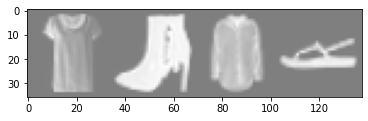

t-shirt ankle boot shirt sandal


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_iter)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_iter, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.400
[1,  4000] loss: 0.750
[1,  6000] loss: 0.642
[1,  8000] loss: 0.585
[1, 10000] loss: 0.523
[1, 12000] loss: 0.515
[1, 14000] loss: 0.479
[2,  2000] loss: 0.433
[2,  4000] loss: 0.431
[2,  6000] loss: 0.406
[2,  8000] loss: 0.412
[2, 10000] loss: 0.396
[2, 12000] loss: 0.387
[2, 14000] loss: 0.375
Finished Training


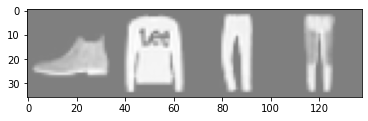

GroundTruth:  ankle boot pullover trouser trouser


In [13]:
dataiter = iter(test_iter)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ankle boot pullover trouser trouser


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_iter:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_iter:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: t-shirt is 80.3 %
Accuracy for class: trouser is 97.0 %
Accuracy for class: pullover is 81.0 %
Accuracy for class: dress is 87.0 %
Accuracy for class: coat  is 82.3 %
Accuracy for class: sandal is 94.0 %
Accuracy for class: shirt is 55.2 %
Accuracy for class: sneaker is 90.8 %
Accuracy for class: bag   is 94.8 %
Accuracy for class: ankle boot is 96.9 %


In [18]:
alex = torch.load("../experiment/DAIR-1/pnp_alex_L1_i20p20g20m5_20220505-12:51:46_0.model", map_location=torch.device('cpu'))


In [19]:
train_iter, test_iter = experiment.load_data_fashion_mnist(batch_size=128, resize=224, flatten=False)

In [20]:
classes = ('t-shirt', 'trouser', 'pullover', 'dress',
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_iter:
        images, labels = data
        outputs = alex(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: t-shirt is 88.2 %
Accuracy for class: trouser is 98.4 %
Accuracy for class: pullover is 88.8 %
Accuracy for class: dress is 93.7 %
Accuracy for class: coat  is 83.5 %
Accuracy for class: sandal is 97.9 %
Accuracy for class: shirt is 68.3 %
Accuracy for class: sneaker is 97.9 %
Accuracy for class: bag   is 98.5 %
Accuracy for class: ankle boot is 95.8 %


In [41]:
model_file = "../experiment/DAIR-1/pnp_alex_L1_i20p20g20m5_20220505-12:51:46_0.model"
alex = torch.load(model_file, map_location=torch.device('cpu'))
train_iter, test_iter = experiment.load_data_fashion_mnist(batch_size=128, resize=224, flatten=False)
classes = ('t-shirt', 'trouser', 'pullover', 'dress',
        'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
# prepare to count Recall for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# Prepare to count Precision for each class
TP = {classname: 0 for classname in classes}
TPFP = {classname: 0 for classname in classes}

# again no gradients needed
# 召回率: 
# 精确率: precision : TP/(TP+FP)
with torch.no_grad():
    for data in test_iter:
        images, labels = data
        outputs = alex(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                TP[classes[prediction]] += 1
            total_pred[classes[label]] += 1
            TPFP[classes[prediction]] += 1
print("[model]")
for classname in classes:
    recall = 100 * float(correct_pred[classname]) / total_pred[classname]
    precision = 100 * float(TP[classname]) / TPFP[classname]
    print(f'For class: {classname:5s}, Recall is {recall:.1f} % , Precision is {precision:.1f} %')
print('-'*40)

[model]
For class: t-shirt, Recall is 86.9 % , Precision is 83.2 %
For class: trouser, Recall is 98.5 % , Precision is 99.2 %
For class: pullover, Recall is 87.8 % , Precision is 83.2 %
For class: dress, Recall is 92.3 % , Precision is 90.1 %
For class: coat , Recall is 83.9 % , Precision is 84.4 %
For class: sandal, Recall is 98.2 % , Precision is 98.8 %
For class: shirt, Recall is 67.5 % , Precision is 76.8 %
For class: sneaker, Recall is 98.7 % , Precision is 95.5 %
For class: bag  , Recall is 97.8 % , Precision is 97.1 %
For class: ankle boot, Recall is 95.7 % , Precision is 98.2 %
----------------------------------------


In [ ]:
def calc_callback_precision(model_id):
    model_file = "../experiment/DAIR-1/pnp2/pnp_alex_L1_i20p20g20m5_20220509-05:09:13_"+str(model_id)+".model"
    alex = torch.load(model_file, map_location=torch.device('cpu'))
    train_iter, test_iter = experiment.load_data_fashion_mnist(batch_size=128, resize=224, flatten=False)
    classes = ('t-shirt', 'trouser', 'pullover', 'dress',
            'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
    # prepare to count Recall for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # Prepare to count Precision for each class
    TP = {classname: 0 for classname in classes}
    TPFP = {classname: 0 for classname in classes}

    # again no gradients needed
    # 召回率: 
    # 精确率: precision : TP/(TP+FP)
    with torch.no_grad():
        for data in test_iter:
            images, labels = data
            outputs = alex(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                    TP[classes[prediction]] += 1
                total_pred[classes[label]] += 1
                TPFP[classes[prediction]] += 1
    print(f"[model {model_id}]")
    for classname in classes:
        recall = 100 * float(correct_pred[classname]) / total_pred[classname]
        precision = 100 * float(TP[classname]) / TPFP[classname]
        print(f'For class: {classname:5s}, Recall is {recall:.1f} % , Precision is {precision:.1f} %')
    print('-'*40)

In [34]:
calc_callback_precision(0)

[model 0]
For class: t-shirt, Recall is 83.4 % , Precision is 85.6 %
For class: trouser, Recall is 97.7 % , Precision is 98.5 %
For class: pullover, Recall is 81.6 % , Precision is 82.6 %
For class: dress, Recall is 90.8 % , Precision is 90.7 %
For class: coat , Recall is 87.8 % , Precision is 77.8 %
For class: sandal, Recall is 97.4 % , Precision is 98.5 %
For class: shirt, Recall is 66.5 % , Precision is 73.7 %
For class: sneaker, Recall is 95.1 % , Precision is 94.7 %
For class: bag  , Recall is 97.9 % , Precision is 97.0 %
For class: ankle boot, Recall is 96.5 % , Precision is 95.3 %
----------------------------------------


In [35]:
calc_callback_precision(1)

[model 1]
For class: t-shirt, Recall is 84.0 % , Precision is 85.2 %
For class: trouser, Recall is 97.8 % , Precision is 99.3 %
For class: pullover, Recall is 85.0 % , Precision is 84.7 %
For class: dress, Recall is 91.9 % , Precision is 89.5 %
For class: coat , Recall is 83.8 % , Precision is 84.1 %
For class: sandal, Recall is 95.7 % , Precision is 98.8 %
For class: shirt, Recall is 72.8 % , Precision is 71.3 %
For class: sneaker, Recall is 96.1 % , Precision is 94.1 %
For class: bag  , Recall is 96.7 % , Precision is 98.3 %
For class: ankle boot, Recall is 95.9 % , Precision is 95.1 %
----------------------------------------


In [36]:
calc_callback_precision(2)

[model 2]
For class: t-shirt, Recall is 86.1 % , Precision is 86.3 %
For class: trouser, Recall is 98.0 % , Precision is 99.4 %
For class: pullover, Recall is 86.0 % , Precision is 84.0 %
For class: dress, Recall is 92.6 % , Precision is 90.0 %
For class: coat , Recall is 84.3 % , Precision is 87.0 %
For class: sandal, Recall is 98.5 % , Precision is 97.8 %
For class: shirt, Recall is 74.2 % , Precision is 75.3 %
For class: sneaker, Recall is 95.8 % , Precision is 95.7 %
For class: bag  , Recall is 97.8 % , Precision is 97.5 %
For class: ankle boot, Recall is 96.0 % , Precision is 96.2 %
----------------------------------------


In [37]:
calc_callback_precision(3)

[model 3]
For class: t-shirt, Recall is 86.6 % , Precision is 87.0 %
For class: trouser, Recall is 98.7 % , Precision is 98.4 %
For class: pullover, Recall is 86.5 % , Precision is 86.8 %
For class: dress, Recall is 91.7 % , Precision is 93.7 %
For class: coat , Recall is 86.6 % , Precision is 86.3 %
For class: sandal, Recall is 98.8 % , Precision is 98.3 %
For class: shirt, Recall is 78.3 % , Precision is 76.4 %
For class: sneaker, Recall is 97.8 % , Precision is 96.4 %
For class: bag  , Recall is 97.7 % , Precision is 98.2 %
For class: ankle boot, Recall is 96.1 % , Precision is 97.8 %
----------------------------------------


In [38]:
calc_callback_precision(4)

[model 4]
For class: t-shirt, Recall is 85.8 % , Precision is 86.8 %
For class: trouser, Recall is 98.3 % , Precision is 99.1 %
For class: pullover, Recall is 86.0 % , Precision is 84.2 %
For class: dress, Recall is 90.7 % , Precision is 91.7 %
For class: coat , Recall is 82.9 % , Precision is 86.4 %
For class: sandal, Recall is 98.0 % , Precision is 98.6 %
For class: shirt, Recall is 76.7 % , Precision is 72.2 %
For class: sneaker, Recall is 97.1 % , Precision is 94.1 %
For class: bag  , Recall is 97.0 % , Precision is 98.8 %
For class: ankle boot, Recall is 94.9 % , Precision is 96.8 %
----------------------------------------


In [39]:
calc_callback_precision(5)

[model 5]
For class: t-shirt, Recall is 88.1 % , Precision is 85.6 %
For class: trouser, Recall is 98.1 % , Precision is 99.3 %
For class: pullover, Recall is 87.4 % , Precision is 85.7 %
For class: dress, Recall is 91.1 % , Precision is 92.3 %
For class: coat , Recall is 88.1 % , Precision is 83.3 %
For class: sandal, Recall is 97.3 % , Precision is 98.7 %
For class: shirt, Recall is 70.9 % , Precision is 78.4 %
For class: sneaker, Recall is 97.9 % , Precision is 94.8 %
For class: bag  , Recall is 98.1 % , Precision is 97.4 %
For class: ankle boot, Recall is 96.4 % , Precision is 97.5 %
----------------------------------------
